This notebook was created to train a model for keypoint facial detction using a large dataset. This notebook is not necessary for the final image morpher but is included to show the training process of the final model. This notebook is configured to run on google colab using GPU hardware acceleration.

Author: Arav Shah

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

ModuleNotFoundError: ignored

In [ ]:
import sys, os, re, json

import matplotlib
import numpy as np
import skimage as sk
import skimage.io as skio
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import math
import pandas as pd

import matplotlib.image as image

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader


from scipy.spatial import Delaunay
from scipy.spatial import tsearch
from scipy import misc
import imageio

import ast
import copy
import xml.etree.ElementTree as ET 
from sklearn.model_selection import train_test_split

In [ ]:
MY_DRIVE = "/content/gdrive/My Drive"
root_folder = os.path.join(MY_DRIVE, "image_morphing") 
sys.path.append(os.path.join(root_folder, "source"))

In [ ]:
# Dataloader

tree = ET.parse(os.path.join(root_folder, 'ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml'))
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

	landmark = []
	for num in range(68):
		x_coordinate = int(filename[0][num].attrib['x'])
		y_coordinate = int(filename[0][num].attrib['y'])
		landmark.append([x_coordinate, y_coordinate])
	landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32') 

In [ ]:
df = pd.DataFrame(bboxes)
df[(df < 0).any(1) == True]

,0,1,2,3
49,77.0,-293.0,1110.0,1234.0
56,67.0,-57.0,373.0,414.0
119,475.0,-141.0,925.0,1028.0
139,160.0,-351.0,2301.0,2556.0
187,-44.0,812.0,773.0,753.0
...,...,...,...,...
6469,-41.0,-82.0,536.0,596.0
6473,-46.0,1206.0,2515.0,2512.0
6548,-13.0,160.0,2301.0,2301.0
6609,-6.0,-27.0,180.0,200.0


In [ ]:
img_filenames[1]

'ibug_300W_large_face_landmark_dataset/helen/trainset/2659264056_1.jpg'

In [ ]:
def set_bound(bound, percent, shape):
  margin = round(bound[2] * percent)
  if bound[0] - margin < 0:
    margin += (bound[0] - margin)
  if bound[0] + bound[2] + margin > shape[1]:
    margin -= (bound[0] + bound[2] + margin - shape[1])
  if bound[1] - margin < 0:
    margin += (bound[1] - margin)
  if bound[1] + bound[3] + margin > shape[0]:
    margin -= (bound[1] + bound[3] + margin - shape[0])

  a = bound[0] - margin
  b = bound[0] + bound[2] + margin
  c = bound[1] - margin
  d = bound[1] + bound[3] + margin

  return a, b, c, d

In [ ]:
def get_im_and_pts(index):
  im = plt.imread(os.path.join(root_folder, img_filenames[index]))
  bound = bboxes[index].astype(int)
  if bound[0] < 0:
    bound[0] = 0
  if bound[1] < 0:
    bound[1] = 0 
  
  a, b, c, d = set_bound(bound, .3, im.shape)

  temp_im = im[c : d, a : b]

  temp_pts = copy.deepcopy(landmarks[index])
  temp_pts[:, 0] -= a
  temp_pts[:, 0] /= temp_im.shape[1]
  temp_pts[:, 1] -= c
  temp_pts[:, 1] /= temp_im.shape[0]

  temp_im = temp_im.astype(np.float32) / 255 - 0.5
  temp_im = resize(temp_im, (224, 224))
  temp_im = rgb2gray(temp_im)

  return temp_im, temp_pts


1739


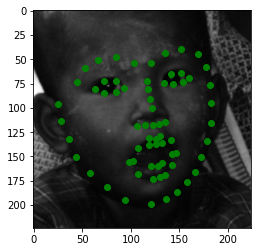

In [ ]:
index = np.random.randint(0, 6665)
print(index)
im, pts = get_im_and_pts(index)

plt.imshow(im + 0.5, cmap = 'gray')
plt.plot(pts[:,0] * 224, pts[:,1] * 224, 'go')
plt.show()

In [ ]:
# Split data into train and test (val) sets
im_names_train, im_names_test, labels_train, labels_test, bbox_train, bbox_test = train_test_split(img_filenames, landmarks, bboxes, test_size=0.10, random_state=42)

In [ ]:
len(im_names_test)

667

In [ ]:
def get_im_and_pts_train(index):
  im = plt.imread(os.path.join(root_folder, im_names_train[index]))
  bound = bbox_train[index].astype(int)
  if bound[0] < 0:
    bound[0] = 0
  if bound[1] < 0:
    bound[1] = 0 
  
  a, b, c, d = set_bound(bound, .3, im.shape)

  temp_im = im[c : d, a : b]

  temp_pts = copy.deepcopy(labels_train[index])
  temp_pts[:, 0] -= a
  temp_pts[:, 0] /= temp_im.shape[1]
  temp_pts[:, 1] -= c
  temp_pts[:, 1] /= temp_im.shape[0]

  temp_im = temp_im.astype(np.float32) / 255 - 0.5
  temp_im = resize(temp_im, (224, 224))
  temp_im = rgb2gray(temp_im)

  return temp_im, temp_pts

def get_im_and_pts_test(index):
  im = plt.imread(os.path.join(root_folder, im_names_test[index]))
  bound = bbox_test[index].astype(int)
  if bound[0] < 0:
    bound[0] = 0
  if bound[1] < 0:
    bound[1] = 0 
  
  a, b, c, d = set_bound(bound, .3, im.shape)

  temp_im = im[c : d, a : b]

  temp_pts = copy.deepcopy(labels_test[index])
  temp_pts[:, 0] -= a
  temp_pts[:, 0] /= temp_im.shape[1]
  temp_pts[:, 1] -= c
  temp_pts[:, 1] /= temp_im.shape[0]

  temp_im = temp_im.astype(np.float32) / 255 - 0.5
  temp_im = resize(temp_im, (224, 224))
  temp_im = rgb2gray(temp_im)

  return temp_im, temp_pts

def get_im_test_colored(index):
  im = plt.imread(os.path.join(root_folder, im_names_test[index]))
  bound = bbox_test[index].astype(int)
  if bound[0] < 0:
    bound[0] = 0
  if bound[1] < 0:
    bound[1] = 0 
  
  a, b, c, d = set_bound(bound, .3, im.shape)

  temp_im = im[c : d, a : b]

  temp_im = temp_im.astype(np.float32) / 255 - 0.5
  temp_im = resize(temp_im, (224, 224))

  return temp_im

1386


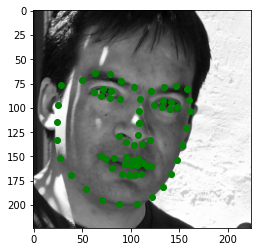

In [ ]:
index = np.random.randint(0, 5998)
print(index)
im, pts = get_im_and_pts_train(index)

plt.imshow(im + 0.5, cmap = 'gray')
plt.plot(pts[:,0] * 224, pts[:,1] * 224, 'go')
plt.show()

In [ ]:
ims_train = [(get_im_and_pts_train(i)) for i in range(len(im_names_train))]

In [ ]:
ims_test = [(get_im_and_pts_test(i)) for i in range(len(im_names_test))]

In [ ]:
model = models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=512, out_features=136, bias=True)

print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Hyperparameters
num_epochs = 5
batch_size = 1
# learning_rate = 0.00035

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


In [ ]:
device

device(type='cuda')

In [ ]:
# Train the model
total_step = len(im_names_train)
val_step = len(im_names_test)
train_loss = []
val_loss = []
total_loss = 0

for epoch in range(num_epochs):
    for i in range(len(im_names_train)):

      # im, labls = get_im_and_pts_train(i)
      im, labls = ims_train[i]
      
      images = torch.from_numpy(im)
      images = torch.unsqueeze(torch.unsqueeze(images, 0), 0).float()
      labls = np.array(labls)
      labels = torch.unsqueeze(torch.from_numpy(labls), 0).float()

      images = images.to(device)
      labels = labels.to(device)
      model.to(device)

      # Run the forward pass
      outputs = model(images).float()
      labels = labels.reshape(labels.size(0), -1)
      loss = criterion(outputs, labels)

      # Backprop and perform Adam optimisation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      total_loss += loss.item()
      
      # if (epoch == num_epochs - 1):
      #     outputs = torch.reshape(outputs, shape = (58, 2))
      #     preds.append(outputs)
      #     ims.append(im)

    avg_loss = total_loss / total_step
    total_loss = 0
    
    for i in range(len(im_names_test)):

      # im, labls = get_im_and_pts_test(i)
      im, labls = ims_test[i]

      images = torch.from_numpy(im)
      images = torch.unsqueeze(torch.unsqueeze(images, 0), 0).float()
      labls = np.array(labls)
      labels = torch.unsqueeze(torch.from_numpy(labls), 0).float()

      images = images.to(device)
      labels = labels.to(device)
      model.to(device)

      # Run the forward pass
      outputs = model(images).float()
      labels = labels.reshape(labels.size(0), -1)
      loss = criterion(outputs, labels)

      total_loss += loss.item()

    v_loss = total_loss / val_step   
    
    print('Epoch [{}/{}], Loss: {:.6f}, Validation Loss: {:.6f}'
          .format(epoch + 1, num_epochs, avg_loss, v_loss))
    
    train_loss.append(avg_loss)
    val_loss.append(v_loss)
    total_loss = 0

Epoch [1/5], Loss: 0.000288, Validation Loss: 0.000616
Epoch [2/5], Loss: 0.000266, Validation Loss: 0.000585
Epoch [3/5], Loss: 0.000245, Validation Loss: 0.000544
Epoch [4/5], Loss: 0.000239, Validation Loss: 0.000555
Epoch [5/5], Loss: 0.000219, Validation Loss: 0.000519


First training iteration: Epoch [10/10], Loss: 0.000509, Validation Loss: 0.000690

Second training iteration (continuing from first): Epoch [5/5], Loss: 0.000305, Validation Loss: 0.000560

Third training iteration (continuing from second): Epoch [5/5], Loss: 0.000219, Validation Loss: 0.000519


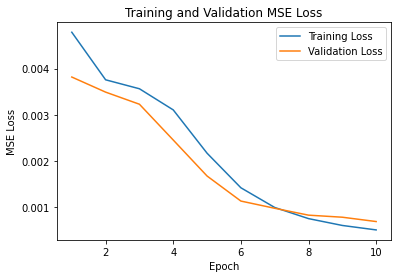

In [ ]:
x = range(1, num_epochs + 1)
plt.plot(x, train_loss, label = "Training Loss")
plt.plot(x, val_loss, label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation MSE Loss')
plt.legend()
# plt.savefig('output_images/face_losses.jpg')
plt.show()

In [ ]:
# save model 
model_name = os.path.join(root_folder, "models/model_{}_epochs.pt".format(num_epochs + 15))
torch.save(model, model_name)

In [ ]:
# Load model and convert model to predict using cpu

model_name = os.path.join(root_folder, "models/model_20_epochs.pt")
model = torch.load(model_name, map_location=torch.device('cpu'))

# device = torch.device("cpu")
# model = model.to(device)

12


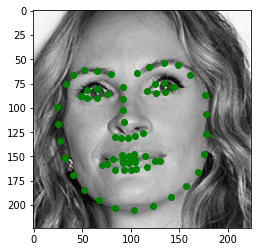

In [ ]:
# Test model CPU

index = np.random.randint(0, 666)
# index = 242
print(index)

im, _ = ims_test[index]

images = torch.from_numpy(im)
images = torch.unsqueeze(torch.unsqueeze(images, 0), 0).float()
outputs = model(images).float()
pts = torch.reshape(outputs, shape = (68, 2)).detach().numpy()

plt.imshow(im + 0.5, cmap = 'gray')
plt.plot(pts[:,0] * 224, pts[:,1] * 224, 'go')
plt.show()

657


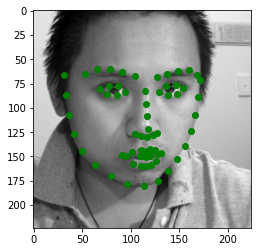

In [ ]:
# Test model GPU

index = np.random.randint(0, 666)
# index = 242
print(index)

im, _ = ims_test[index]

images = torch.from_numpy(im)
images = torch.unsqueeze(torch.unsqueeze(images, 0), 0).float()
images = images.to(device)
outputs = model(images).float().cpu()
pts = torch.reshape(outputs, shape = (68, 2)).detach().numpy()

plt.imshow(im + 0.5, cmap = 'gray')
plt.plot(pts[:,0] * 224, pts[:,1] * 224, 'go')
plt.show()

In [ ]:
CORNERS = [[0,0], [0, 223], [223, 0], [223, 223]]
CORNERS = np.array(CORNERS)
FRAMES = 45

def computeAffine(tri1_pts, tri2_pts):
    A = np.matrix("{} {} 1 0 0 0;".format(tri1_pts[0][0], tri1_pts[0][1])
                 +"0 0 0 {} {} 1;".format(tri1_pts[0][0], tri1_pts[0][1])
                 +"{} {} 1 0 0 0;".format(tri1_pts[1][0], tri1_pts[1][1])
                 +"0 0 0 {} {} 1;".format(tri1_pts[1][0], tri1_pts[1][1])
                 +"{} {} 1 0 0 0;".format(tri1_pts[2][0], tri1_pts[2][1])
                 +"0 0 0 {} {} 1".format(tri1_pts[2][0], tri1_pts[2][1]))

    b = np.matrix("{} {} {} {} {} {}".format(tri2_pts[0][0], tri2_pts[0][1], tri2_pts[1][0], tri2_pts[1][1], tri2_pts[2][0], tri2_pts[2][1]))
    b = np.transpose(b)
    
    result = np.vstack((np.reshape(np.linalg.lstsq(A, b, rcond=None)[0], (2, 3)), [0, 0, 1]))

    return result

def findAffine(tri, im_points, mid_points):
    result = []
    for x in tri.simplices:
        result.append(computeAffine(im_points[x, ], mid_points[x, ]))
        
    return result

def findMidWayFace(im1, im2, im1_points, im2_points, mid_points, tri, w):
    im1_affine_matrices = findAffine(tri, im1_points, mid_points)
    im2_affine_matrices = findAffine(tri, im2_points, mid_points)
    
    out_im = np.ones(im1.shape)
    
    for y in range(im1.shape[0]):
        for x in range(im1.shape[1]):
            i = tsearch(tri, (x, y))
            im1_affined_pts = np.dot(np.linalg.inv(im1_affine_matrices[i]), [x, y, 1])
            im2_affined_pts = np.dot(np.linalg.inv(im2_affine_matrices[i]), [x, y, 1])

            temp1 = im1[np.int64(im1_affined_pts[0, 1]), np.int64(im1_affined_pts[0, 0]), :] * w
            temp2 = im2[np.int64(im2_affined_pts[0, 1]), np.int64(im2_affined_pts[0, 0]), :] * (1-w)
            
            out_im[y, x, :] = temp1 + temp2

    return out_im

def findAverageShape(im1_points, im2_points, w):
    ave_shape = []
    for i in range(len(im1_points)):
        ave_shape.append([w * im1_points[i][0] + (1 - w) * im2_points[i][0], w * im1_points[i][1] + (1 - w) * im2_points[i][1]])

    return np.array(ave_shape)


# Moprhing function

def morph(im1, im2, im1_points, im2_points):
    weights = np.linspace(0.0, 1.0, FRAMES)
    out_frames = []
        
    for i in range(FRAMES):
        mid_Points = findAverageShape(im1_points, im2_points, weights[i])
        frame = findMidWayFace(im1, im2, im1_points, im2_points, mid_Points, Delaunay(mid_Points), weights[i])
        final_frame = (frame + 0.5) * 255
        if i == 0:
          out_frames.append(final_frame.astype(np.uint8))
        out_frames.append(final_frame.astype(np.uint8))
        
    out_frames.append(final_frame.astype(np.uint8))
    return out_frames 

199


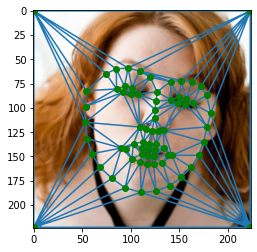

In [ ]:
id1 = np.random.randint(0, 666)
print(id1)

temp_im1, _ = ims_test[id1]
im1 = get_im_test_colored(id1)

images = torch.from_numpy(temp_im1)
images = torch.unsqueeze(torch.unsqueeze(images, 0), 0).float()

outputs = model(images).float()
pts = torch.reshape(outputs, shape = (68, 2)).detach().numpy()
pts[:,0] *= 224
pts[:,1] *= 224
im1_pts = np.concatenate((pts, CORNERS), axis = 0)


plt.imshow(im1 + 0.5, cmap = 'gray')
plt.triplot(im1_pts[:, 0], im1_pts[:, 1], Delaunay(im1_pts).simplices)
plt.plot(im1_pts[:,0], im1_pts[:,1], 'go')
plt.show()


99


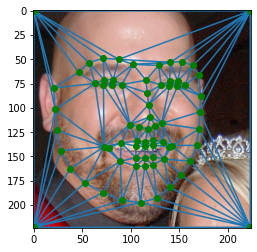

In [ ]:
id2 = np.random.randint(0, 666)
print(id2)

temp_im2, _ = ims_test[id2]
im2 = get_im_test_colored(id2)

images = torch.from_numpy(temp_im2)
images = torch.unsqueeze(torch.unsqueeze(images, 0), 0).float()

outputs = model(images).float()
pts = torch.reshape(outputs, shape = (68, 2)).detach().numpy()
pts[:,0] *= 224
pts[:,1] *= 224
im2_pts = np.concatenate((pts, CORNERS), axis = 0)


plt.imshow(im2 + 0.5, cmap = 'gray')
plt.triplot(im2_pts[:, 0], im2_pts[:, 1], Delaunay(im2_pts).simplices)
plt.plot(im2_pts[:,0], im2_pts[:,1], 'go')
plt.show()

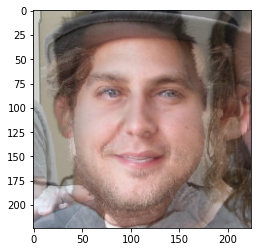

In [ ]:
mid_Points = findAverageShape(im1_pts, im2_pts, 0.5)
triMid = Delaunay(mid_Points)
mid_way_im = findMidWayFace(im1, im2, im1_pts, im2_pts, mid_Points, triMid, 0.5)
# final_mid_way_im = np.clip(mid_way_im/255, 0, 1)
# # plt.imsave("output_images/midwayface.jpg", final_mid_way_im)

plt.imshow(mid_way_im + .5)

In [ ]:
import multiprocessing

multiprocessing.cpu_count()

8

In [ ]:
# Moprhing parallelized

def morph_parallel(i, im1, im2, im1_points, im2_points):
    weights = np.linspace(0.0, 1.0, FRAMES)
        
    mid_Points = findAverageShape(im1_points, im2_points, weights[i])
    frame = findMidWayFace(im1, im2, im1_points, im2_points, mid_Points, Delaunay(mid_Points), weights[i])
    final_frame = (frame + 0.5) * 255
    res = final_frame.astype(np.uint8)

    return res

In [ ]:
# Parallize the morphing code using dask. I am not seeing huge speed improvements but there are some. This could work better locally rather than on collab.

import dask

results = []

for i in range(FRAMES):
  temp = dask.delayed(morph_parallel)(i, im2, im1, im2_pts, im1_pts)
  results.append(temp)

fframes = dask.compute(results)
exportname = os.path.join(root_folder, "output_images/parallel_morph_test_im_{}_and_{}.gif".format(id1, id2))
imageio.mimsave(exportname, fframes[0], format='GIF', duration= 2.5/FRAMES)

In [ ]:
# Previous attempt at parallization. Slowed down the execution :(

# from itertools import repeat
# from multiprocessing import Pool

# pool = Pool(4)
# a_args = range(FRAMES)
# results = pool.starmap(morph_parallel, zip(a_args, repeat(im2), repeat(im1), repeat(im2_pts), repeat(im1_pts)))

In [ ]:
#morph sequence (no parallization)

out_frames = morph(im2, im1, im2_pts, im1_pts)
exportname = os.path.join(root_folder, "output_images/morph_test_im_{}_and_{}.gif".format(id1, id2))
imageio.mimsave(exportname, out_frames, format='GIF', duration= 2.5/FRAMES)